# Large Scale Batch Inference on HopsFS

To run this notebook you must first install the following libraries in your project's conda environment (in addition to the base libraries):

- Pillow
- Matplotlib

Moreover, the notebook assumes that you have access to the ImageNet dataset, this can either be uploaded to your project or shared from another project.

You also need access to an internet connection so that the pre-trained model can be downloaded.

## Imports

In [40]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from hops import experiment
from hops import tensorboard
from hops import featurestore
from hops import hdfs
from hops import util
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from PIL import Image
import numpy as np
from tensorflow.keras.models import load_model
import tensorflow.keras.models
import types
import tempfile
from pyspark.sql import DataFrame, Row
import pydoop.hdfs as pydoop

In [41]:
%%local
import matplotlib.pyplot as plt
import tensorflow as tf
import pydoop.hdfs as pydoop
from hops import hdfs

## Constants

In [42]:
HEIGHT =224
WIDTH = 224
BATCH_SIZE = 100
CHANNELS = 3
INPUT_SHAPE = 12288
NUM_CLASSES = 1000
NUM_PARALLEL_CALLS = 8
SAMPLE_IMAGE_DIR = pydoop.path.abspath(hdfs.project_path("labs") + "/imagenet_2016/ILSVRC2016_CLS-LOC/ILSVRC/Data/CLS-LOC/train/n03617480/")
SAMPLE_IMAGE_NAME = "n03617480_28686.JPEG"
SAMPLE_IMAGE_PATH = SAMPLE_IMAGE_DIR + SAMPLE_IMAGE_NAME
MODEL_NAME = "resnet_imagenet.h5"

In [43]:
%%local
HEIGHT =224
WIDTH = 224
CHANNELS = 3
INPUT_SHAPE = 12288
NUM_CLASSES = 1000
BATCH_SIZE = 100
NUM_PARALLEL_CALLS = 8
SAMPLE_IMAGE_DIR = pydoop.path.abspath(hdfs.project_path("labs") + "/imagenet_2016/ILSVRC2016_CLS-LOC/ILSVRC/Data/CLS-LOC/train/n03617480/")
SAMPLE_IMAGE_NAME = "n03617480_28686.JPEG"
SAMPLE_IMAGE_PATH = SAMPLE_IMAGE_DIR + SAMPLE_IMAGE_NAME
MODEL_NAME = "resnet_imagenet.h5"

## Load Pre-Trained ResNet50 Model Trained on ImageNet from Keras.applications

In [44]:
def define_model():
    """
    Defines the model to use for image classification
    
    Returns:
           ResNet50 model
    """
    tf.keras.backend.set_learning_phase(False)
    model = ResNet50(weights="imagenet", input_shape=(HEIGHT, WIDTH, CHANNELS), classes=NUM_CLASSES)
    return model

## Save Pre-Trained model to HopsFS

In [45]:
def save_model(model):
    """
    Save Pre-Trained ImageNet model to HDFS
    
    Args:
         :model: the pre-trained model with weights trained on imagenet
    Returns:
          The HDFS path where it is saved
    """
    # save trained model
    model.save(MODEL_NAME) #Keras can't save to HDFS in the current version so save to local fs first
    hdfs.copy_to_hdfs(MODEL_NAME, hdfs.project_path() + "Resources/", overwrite=True) # copy from local fs to hdfs
    model_hdfs_path = hdfs.project_path() + "Resources/" + MODEL_NAME
    return model_hdfs_path

In [28]:
hdfs_model_path = save_model(define_model())

In [52]:
hdfs_model_path

'hdfs://10.0.104.196:8020/Projects/EndToEndV2/Resources/resnet_imagenet.h5'

## Load Pre-Trained model From HopsFS

In [30]:
local_model_path = hdfs.copy_to_local(hdfs_model_path, "", overwrite=True) + MODEL_NAME

In [31]:
model = load_model(MODEL_NAME)

## Batch Inference on ImageNet using Spark + Keras

#### Read Images into a Spark Dataframe

In [32]:
spark.conf.set("spark.sql.files.ignoreCorruptFiles", "true")
df = spark.read.option("mode", "DROPMALFORMED").format("image").load("hdfs://10.0.104.196:8020/Projects/labs/imagenet_2016/ILSVRC2016_CLS-LOC/ILSVRC/Data/CLS-LOC/train/*/")

In [33]:
df_filtered = df.select("image.origin")

#### Count how many images to perform batch inference on

ImageNet2016 contains 1281167 images in the training dataset.

In [139]:
df_filtered.count()

1281167

#### Parallel Inference using Spark Executors

In [74]:
def inference_fn(partition):
    from hops import hdfs
    try:
        local_model_path = hdfs.copy_to_local(hdfs_model_path, "", overwrite=True) + MODEL_NAME
        model = load_model(MODEL_NAME)
    except:
        print("could not copy model to local")
    for row in partition:
        # some rows in imagenet are malformed so we skip those
        try:
            IMAGE_NAME = row.origin.rsplit('/', 1)[1]
            local_sample_image_path = hdfs.copy_to_local(row.origin, "", overwrite=True) + IMAGE_NAME
            img = image.load_img(local_sample_image_path, target_size=(HEIGHT, WIDTH))
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)
            predictions = model.predict(x)
            decoded_predictions = decode_predictions(predictions, top=3)
            top_1_id = str(decoded_predictions[0][0][0])
            top_1_label = str(decoded_predictions[0][0][1])
            top_1_confidence = float(decoded_predictions[0][0][2])
            top_2_id = str(decoded_predictions[0][1][0])
            top_2_label = str(decoded_predictions[0][1][1])
            top_2_confidence = float(decoded_predictions[0][1][2])
            top_3_id = str(decoded_predictions[0][2][0])
            top_3_label = str(decoded_predictions[0][2][1])
            top_3_confidence = float(decoded_predictions[0][2][2])    
            Example = Row("image_path", "top1_id", "top1_label", "top1_confidence", "top2_id", 
                          "top2_label", "top2_confidence", "top3_id", "top3_label", "top3_confidence")
            print("Labelled example successfully")
            yield Example(row.origin, top_1_id, top_1_label, top_1_confidence, top_2_id, top_2_label, top_2_confidence,
                          top_3_id, top_3_label, top_3_confidence)
        except:
            print("Failed to label row")

In [75]:
labeled_df = df_filtered.limit(10000).repartition(util.num_executors()*3).rdd.mapPartitions(inference_fn).toDF()

In [76]:
labeled_df.write.mode("overwrite").parquet(hdfs.project_path() + "Resources/labels.parquet")

In [142]:
labeled_df.printSchema()

root
 |-- image_path: string (nullable = true)
 |-- top1_id: string (nullable = true)
 |-- top1_label: string (nullable = true)
 |-- top1_confidence: double (nullable = true)
 |-- top2_id: string (nullable = true)
 |-- top2_label: string (nullable = true)
 |-- top2_confidence: double (nullable = true)
 |-- top3_id: string (nullable = true)
 |-- top3_label: string (nullable = true)
 |-- top3_confidence: double (nullable = true)

### Compare Prediction against Image

We can do a simple test to compare an image in the dataframe against a predicted label

In [143]:
row = labeled_df.first()

Copy the HDFS path below to the %%local cell to plot it.

In [144]:
row.image_path

'hdfs://10.0.104.196:8020/Projects/labs/imagenet_2016/ILSVRC2016_CLS-LOC/ILSVRC/Data/CLS-LOC/train/n04550184/n04550184_41732.JPEG'

In [145]:
row.top1_label

'wardrobe'

In [146]:
row.top2_label

'entertainment_center'

In [147]:
row.top3_label

'bookcase'

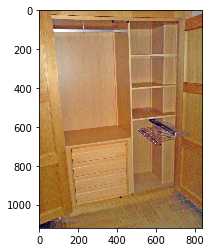

In [149]:
%%local
%matplotlib inline 
with tf.Session() as sess:
    sample_img = tf.image.decode_jpeg(tf.read_file("hdfs://10.0.104.196:8020/Projects/labs/imagenet_2016/ILSVRC2016_CLS-LOC/ILSVRC/Data/CLS-LOC/train/n04550184/n04550184_41732.JPEG")).eval()
    plt.imshow(sample_img)
    plt.show()